# Описание проекта

**Проект по теме "Как рассказать историю с помощью данных"**

В процессе рассмотрения бизнес-идея - открытие кафе, в котором будут обсулуживать роботы. 

Для открытия требуется привлечение инвестиций, а это, в свою очередь, требует обоснования. Предполагается, что на старте кафе будет популярно в силу новой "фишки", однако в перспективе развитие ситуации не очевидно. 

В распоряжении - открытые данные о заведениях общепита в Москве. Их необходимо проанализировать и подготовить ответ на поставленный вопрос. 

# Подготовка данных

## Импорт библиотек и чтение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io as io
from io import BytesIO

In [2]:
data = pd.read_csv('/datasets/rest_data.csv') #читаем исходные данные

In [3]:
pd.set_option('display.max_columns', None)  
pd.options.display.max_colwidth = 150  

## Предобработка данных

In [4]:
#получим общие данные о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
#посмотрим непосредственно на сами данные 
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Можем видеть, что тип данных используется корректно:

1. Тип данных в столбцах `id` и `number` - целое число, что соответствует действительности
2. В остальных столбцах используется строковый тип данных, что совпадает с действительностью
3. Мы видим, что некоторые наименования объектов указаны целиком в верхнем регистре. Если одно и то же значение (слово, фраза) будут указаны в разных регистрах, то и при анализе они будут учитываться как различные значения, поэтому требуется преобразование в нижний или верхний регистр для удобства работы

### Столбец `id`

In [6]:
#убедимся, что в столбце с идентификаторами используются только уникальные значения
print('Количество уникальных значений в столбце с идентификаторами заведений:', len(data['id'].unique()))

Количество уникальных значений в столбце с идентификаторами заведений: 15366


### Столбцы `object_name` и `chain`

Мы знаем, что в данном столбце отсутствуют пропуски. По этой причине попробуем оценить наполнение столбца путем группировки записей по наименованию. 

In [7]:
#как и указывалось ранее, преобразуем наименования объектов в один регистр
data['object_name'] = data['object_name'].str.lower()

In [8]:
#сформируем датафрейм, в котором сгруппируем имеющиеся объекты по наименованию
grouped_by_name = data.groupby('object_name', as_index=False).agg({'id': 'count'}).sort_values(by='id', ascending=False)
grouped_by_name.columns=['name', 'same_name_objects']
grouped_by_name.head(20)

,name,same_name_objects
7639,столовая,321
3468,кафе,278
9463,шаурма,250
9798,шоколадница,158
623,kfc,155
5439,макдоналдс,151
1955,бургер кинг,137
8792,теремок,94
5150,крошка картошка,90
2982,домино'с пицца,90


Судя по данным, мы можем выделить две группы заведений:

1. Если в строке более 1 заведения, то это - сеть
2. Если в строке более 1 заведения, то у этих заведений совпадают наименования (у объекта нет наименования сети)

Имея эту информацию, мы можем оценить корректность заполнения столбца `chain`

In [9]:
#добавим в исходный датафрейм данные о количестве заведений с идентичным наименованием
data = data.merge(grouped_by_name, left_on='object_name', right_on='name', how='left')
del data['name']

In [10]:
data.head(15)
#мы получили информацию о том, сколько отдельных заведений в "сети", но эта информация может быть не слишком достоверной
#так как под вопросом валидация данных, введенных в поле "object_name"

,id,object_name,chain,object_type,address,number,same_name_objects
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,1
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,1
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,1
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,2
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,1
5,27429,стол. при гоу сош № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240,1
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,8
7,20957,буфет мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",90,1
8,20958,кпф семья-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",150,1
9,28858,столовая мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",120,1


In [11]:
#посмотрим, есть ли ошибки с вводом данных
data[(data['chain'] == 'да') & (data['same_name_objects'] == 1)]

,id,object_name,chain,object_type,address,number,same_name_objects
30,24387,готика,да,ресторан,"город Москва, Ангарская улица, дом 39",65,1
39,88194,tajj mahal,да,ресторан,"город Москва, улица Арбат, дом 6/2",100,1
76,22805,хинкальная city,да,кафе,"город Москва, Башиловская улица, дом 19",63,1
116,25796,пиццерия «академия»,да,кафе,"город Москва, Большая Бронная улица, дом 2/6",43,1
129,45561,grand cru,да,кафе,"город Москва, Малая Бронная улица, дом 22, строение 1",45,1
...,...,...,...,...,...,...,...
15255,218284,marmalato,да,ресторан,"город Москва, Хорошёвское шоссе, дом 27",0,1
15341,211269,лаундж-бар «мята lounge»,да,бар,"город Москва, Днепропетровская улица, дом 2Б",45,1
15343,211767,бар мята lounge,да,бар,"город Москва, Митинская улица, дом 16",5,1
15344,206756,мята lounge октябрьская,да,кафе,"город Москва, Донская улица, дом 11, строение 2",48,1


Итак, мы видим, что в исходной таблице содержатся записи с неоднозначным написанием наименования объекта - вероятно на этапе ввода не проводилась валидация. По косвенным признакам мы можем предположить, что заведения, содержащие некоторые ключевые слова относятся к одной сети, но нельзя быть уверенным полностью. 

**Кроме того, в задачи анализа не входит анализ, затрагивающий наименования объектов, поэтому мы остановимся на том, что неточность в данных есть, но она не влияет на достоверность результатов анализа.** 

In [12]:
#пример неоднозначного написания названия заведения на примере объектов со словом "мята" в наименовании
data[(data['chain'] == 'да') & (data['same_name_objects'] == 1) & (data['object_name'].str.contains('мята'))]

,id,object_name,chain,object_type,address,number,same_name_objects
12119,174947,кальян-бар «мята lounge»,да,кафе,"город Москва, Липецкая улица, дом 2, корпус 7",22,1
12120,189056,кальян- бар «мята lounge»,да,бар,"город Москва, Шипиловская улица, дом 44А",45,1
12265,190909,мята lounge шаболовка,да,кафе,"город Москва, улица Серпуховский Вал, дом 21, корпус 1",48,1
13496,202412,мята lounge автозаводская,да,бар,"город Москва, улица Ленинская Слобода, дом 26, строение 2",40,1
15341,211269,лаундж-бар «мята lounge»,да,бар,"город Москва, Днепропетровская улица, дом 2Б",45,1
15343,211767,бар мята lounge,да,бар,"город Москва, Митинская улица, дом 16",5,1
15344,206756,мята lounge октябрьская,да,кафе,"город Москва, Донская улица, дом 11, строение 2",48,1
15347,222491,кальянная «мята lounge»,да,кафе,"город Москва, Профсоюзная улица, дом 142, корпус 1, строение 1",40,1


In [13]:
#оценим значения столбца chain на предмет постронних записей
data['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

### Столбец `object_type`

In [14]:
#посмотрим, как распределились значения по типам и нет ли среди них дубликатов
data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [15]:
#сформируем датафрейм с количеством заведений каждого типа для сетевых заведений и посчитаем среднее количество мест
data_grouped = data[data['chain'] == 'да']

data_grouped = data_grouped.groupby(['object_type', 'object_name'], as_index=False).agg({'number': 'mean', 'address': 'count'})\
.round(1).sort_values('address', ascending=False)

data_grouped.columns=['type', 'name', 'mean_number', 'objects']

data_grouped[data_grouped['name'] == 'kfc']

,type,name,mean_number,objects
470,предприятие быстрого обслуживания,kfc,59.9,99
607,ресторан,kfc,55.0,30
83,кафе,kfc,38.5,26


В данных есть особенность, которая может "смазать" выводы. 

Например, мы можем наблюдать в строке с индексом 470 и строке с индексом 607 заведение с одинаковыми наименованиями (kfc), но разным типом заведения. Можно было бы предположить, что одно и то же заведения с разными типами может иметь отличия по некоторым признакам (например, количеству посадочных мест), но на примере kfc мы видим схожее количество мест (при этом, с перевесом в сторону типа "предприятие быстрого обслуживания").

Учитывая, что мы ранее уже зафиксировали расхождения в наименованиях заведений, предположим, что разные типы заведений - это неточность внесения данных. Поэтому для анализируемого фрагмента мы сделаем стандартизацию типа заведения по принципу: если у какого-либо типа заведения из нескольких для одного и того же наименования объекта больше заведений, то этот тип становится дефолтным. 

In [16]:
#нам нужна таблица, в которую мы запишем наименование заведения и максимальное количество объектов для него
name_max_objs = data_grouped.groupby('name', as_index=False).agg({'objects': 'max'})

#далее нам надо получить соответствующий тип заведения для этого имени объекта
name_max_objs = name_max_objs.merge(data_grouped[['name', 'type', 'objects']] , on=['name', 'objects'], how='left')

#удалим количество объектов по типу из датафрема с типами заведений 
del name_max_objs['objects']

#в исходный датафрейм добавим данные по типу, установленному для сетевых заведений
data = data.merge(name_max_objs, left_on='object_name', right_on='name', how='outer').drop_duplicates('id')
del data['name']

#создадим функцию, которая подменит "некорректные" значения 
def type_swapper(row): 
    if pd.isna(row['type']) or row['object_type'] == row['type']:
        row['object_type'] = row['object_type']
    elif pd.notna(row['type']) and row['object_type'] != row['type']:
        row['object_type'] = row['type']
    return row

In [17]:
#применим функцию к исходному датафрейму
data = data.apply(type_swapper, axis=1)

#удаляем ранее добавленный столбец
del data['type']

In [18]:
#сформируем датафрейм с количеством заведений каждого типа для сетевых заведений и посчитаем среднее количество мест
data_grouped = data[data['chain'] == 'да']

data_grouped = data_grouped.groupby(['object_type', 'object_name'], as_index=False).agg({'number': 'mean', 'address': 'count'})\
.round(1).sort_values('address', ascending=False)

data_grouped.columns=['type', 'name', 'mean_number', 'objects']

#для примера посмотрим, как теперь выглядят данные для заведения "kfc", которое ранее имело 3 разных типа
data_grouped[data_grouped['name'] == 'kfc']

,type,name,mean_number,objects
334,предприятие быстрого обслуживания,kfc,55.3,155


Таким образом, после исправления разночтений в типах заведений, мы получим более четкую картину при анализе заведений с учетом их типов.

### Столбец `address`

In [19]:
data.head(10)

,id,object_name,chain,object_type,address,number,same_name_objects
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,1
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,1
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,1
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,2
4,135770,пиццетория,да,кафе,"город Москва, Дубнинская улица, дом 53, корпус 1",25,2
5,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,1
6,27429,стол. при гоу сош № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240,1
7,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,8
8,111162,брусника,да,кафе,"город Москва, проспект Мира, дом 49",40,8
9,77314,брусника,да,кафе,"город Москва, улица Маросейка, дом 6-8, строение 1",62,8


Нам известно, что все строки с адресами заполнены. 

Предположительно, запись адреса имеет структуру: **город/улица/номер** с четким разделением через запятую. Вероятно будут выявлены некоторые особенности записи адреса, но на этапе предобработки дополнительные действия не требуются. 

### Столбец `number`

Мы знаем, что столбец содержит данные о количестве посадочных мест. В данных мы наблюдаем 1621 запись с количеством посадочных мест, равном нулю. Будем предполагать, что нулевое значение - это точки, в которых действительно таких посадочных мест нет (например, "окошки" на улице).

In [20]:
data['number'].value_counts().head(10)

0     1621
40     835
20     727
30     685
10     644
50     560
60     472
80     464
15     360
45     360
Name: number, dtype: int64

In [21]:
data['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Мы наблюдаем максимальное значение на отметке в 1700 посадочных мест, что вызывает вопросы относительно корректности данных. Отберем 1% "крайних" значений, где будут лежать выбросы. 

In [22]:
data[data['number'] > np.percentile(data['number'], 99)].sort_values(by='number', ascending=False).head(15)

,id,object_name,chain,object_type,address,number,same_name_objects
14045,199696,arena by soho family,нет,бар,"город Москва, Кутузовский проспект, дом 36, строение 11",1700,1
10675,80291,банкетный зал шелк,нет,ресторан,"город Москва, Большой Саввинский переулок, дом 12, строение 10Г",1500,1
10809,27750,столовая-буфет,нет,столовая,"город Москва, улица Волхонка, дом 15",1400,2
11401,19719,комбинат питания «управление академсервис»,нет,столовая,"город Москва, проспект Вернадского, дом 84, строение 1",1288,1
7056,27024,рум сервис,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, строение 1",1200,2
7055,27026,рум сервис,нет,ресторан,"город Москва, площадь Европы, дом 2",1200,2
5775,26560,ресторан «альфа»,нет,ресторан,"город Москва, Измайловское шоссе, дом 71, корпус А",1040,1
12176,171116,eataly,нет,ресторан,"город Москва, Киевская улица, дом 2",920,1
8797,29232,столовая московский гуманитарный университет,нет,столовая,"город Москва, улица Юности, дом 5, строение 1",760,1
14415,200905,white hall,нет,ресторан,"город Москва, Ферганская улица, дом 8",700,1


Мы наблюдаем несколько заведений с количеством посадочных мест у отметки в 1000 и более. По субъективной оценке, данные значению имеют место быть, но такие цифры скорее - общая вместимость заведений, а не количество посадочных мест внутри них. Хотя продажа еды и напитков в таких заведениях, предположительно, не затрудняется особенностями "посадочного" места, поэтому предположим, что эти данные не требует коррекции.

## Заключение по результатам предобработки данных

1. В нашем распоряжении 1 таблица, в которой содержится описание различных заведений общественного питания, расположенных в Москве
2. Таблица содержит 15366 записей
3. Таблица содержит 6 столбцов. Пропуски данных в столбцах отсутствуют.
4. Во всех столбцах изначально используется корректный тип данных
5. В столбце `object_name` предположительно содержатся наименования заведений одной сети с разным написанием. Это можно классифицировать как ошибку, но на цели анализа это не влияет
6. Столбец `chain` содержит только два логически допустимых значения
7. Столбец `object_type` - категорийная переменная. Дубликатов или некорректных вариантов написания не содержит. 
8. Столбец `number` корректировки не требует

# Анализ данных

## Cоотношение видов объектов общественного питания по количеству

In [23]:
data.head()

,id,object_name,chain,object_type,address,number,same_name_objects
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,1
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,1
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,1
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,2
4,135770,пиццетория,да,кафе,"город Москва, Дубнинская улица, дом 53, корпус 1",25,2


In [24]:
#сгруппируем исходные данные по типу заведения и подсчитаем количество заведений каждого типа
objects_by_types = data.groupby('object_type', as_index=False).agg({'address': 'count'}).sort_values(by='address', ascending=False)
objects_by_types.columns=['type', 'objects']
objects_by_types

,type,objects
3,кафе,6157
8,столовая,2583
7,ресторан,2174
6,предприятие быстрого обслуживания,2158
0,бар,840
1,буфет,575
4,кафетерий,355
2,закусочная,319
5,магазин (отдел кулинарии),205


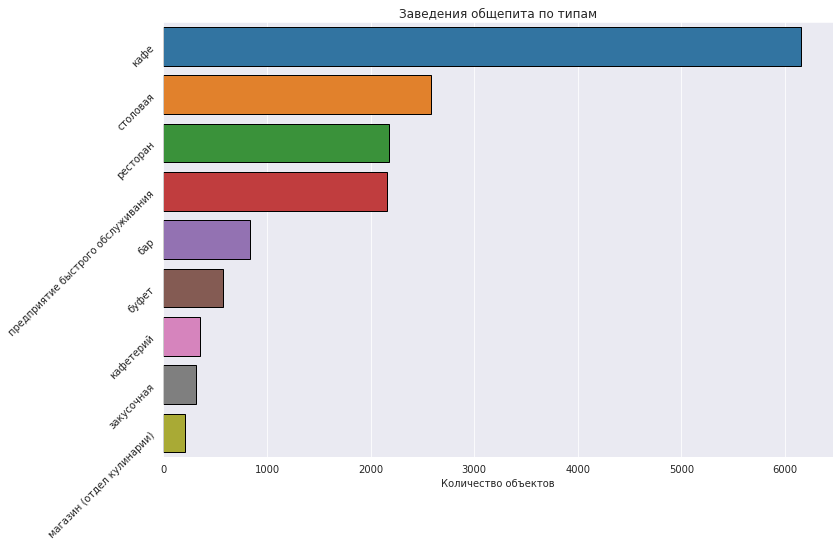

In [25]:
#построим гистограмму
sns.set_style("darkgrid")
plt.figure(figsize=[12, 8]) #задаем размер фигуры
plt.yticks(rotation=45) #наклоняем подписи так, чтобы они читались, но занимали меньше места

obj_by_types = sns.barplot(
    x='objects',
    y='type',
    data=objects_by_types,
    orient='h', #ориентируем график горизонтально
    edgecolor = "black" #наносим на столбцы черные контурные линии
)

obj_by_types.set(
    title='Заведения общепита по типам', 
    xlabel='Количество объектов',
    ylabel=''
)

plt.show()

In [26]:
#также взглянем на среднее количество мест в заведении каждого типа
type_places = data.groupby('object_type', as_index=False).agg({'number': 'mean'}).sort_values(by='number', ascending=False).round(1)

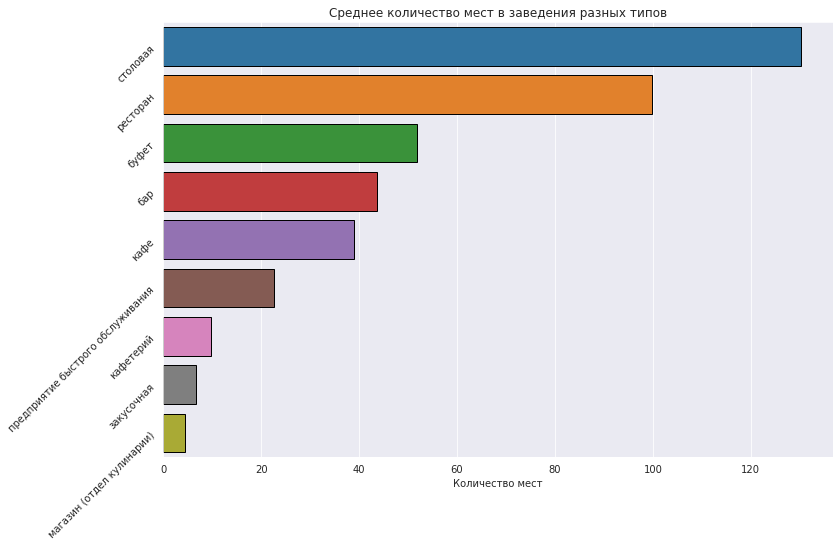

In [27]:
#построим гистограмму
sns.set_style("darkgrid")
plt.figure(figsize=[12, 8]) #задаем размер фигуры
plt.yticks(rotation=45) #наклоняем подписи так, чтобы они читались, но занимали меньше места

obj_by_types = sns.barplot(
    x='number',
    y='object_type',
    data=type_places,
    orient='h', #ориентируем график горизонтально
    edgecolor = "black" #наносим на столбцы черные контурные линии
)

obj_by_types.set(
    title='Среднее количество мест в заведения разных типов', 
    xlabel='Количество мест',
    ylabel=''
)

plt.show()

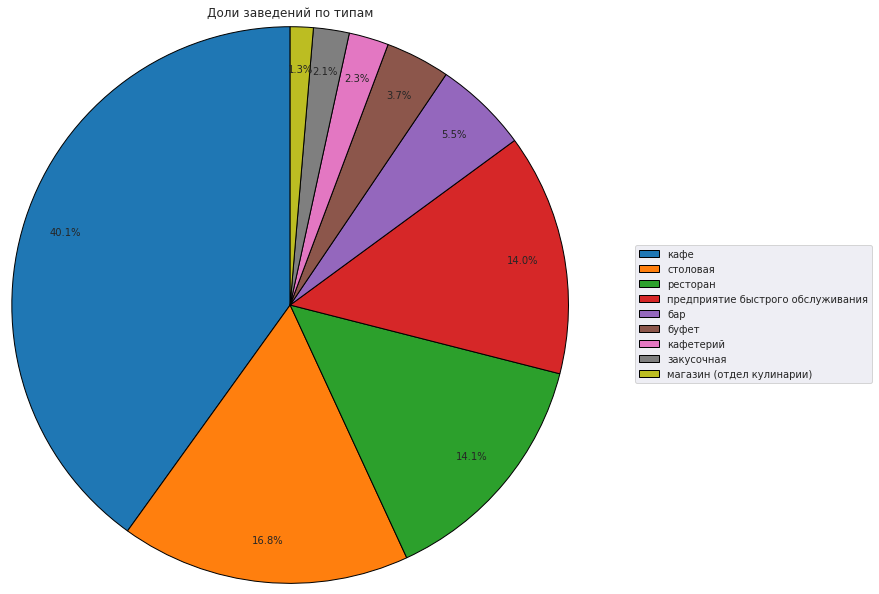

In [28]:
plt.pie(
    objects_by_types['objects'],
    wedgeprops={'edgecolor': 'black'},
    startangle=90,
    autopct='%1.1f%%',
    pctdistance=0.85,
    radius=3.2
)

plt.legend(
    objects_by_types['type'],
    loc='upper right',
    bbox_to_anchor=(3.2, 0.8)
)

plt.title('Доли заведений по типам', y=1.8)
plt.show()

Наблюдаем следующее: 

1. Наибольшее количество заведений - около 6000 (порядка 40%) относятся к типу "кафе". Можем предположить, что данные тип наиболее универсальный: он не вызывает у посетителей ассоциаций с чем-то "дешевым", не предъявляет особенных высоких требований к оснащению и поэтому удобен для реализации
2. В топ 4 помимо кафе также попадают типы (каждая из трех долей более чем вдвое меньше доли "кафе" при сопоставимой общей доле порядка 44% или 6500-7000 заведений: 
    + Столовая 
    + Ресторан 
    + Предприятие быстрого обслуживания

## Cоотношение сетевых и несетевых заведений по количеству

In [29]:
objects_by_chain = data.groupby('chain', as_index=False).agg({'address': 'count'})
objects_by_chain.columns=['is_chain', 'objects']
objects_by_chain

,is_chain,objects
0,да,2968
1,нет,12398


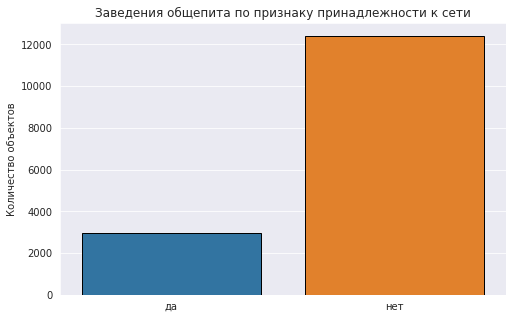

In [30]:
#построим гистограмму
plt.figure(figsize=[8, 5]) 

obj_by_chain = sns.barplot(
    x='is_chain',
    y='objects',
    data=objects_by_chain,
    edgecolor = "black"
)

obj_by_chain.set(
    title='Заведения общепита по признаку принадлежности к сети', 
    xlabel='',
    ylabel='Количество объектов'
)

plt.show()

Около 3000 объектов (порядка 17-18% от общего числа) относятся к сетевым заведениям. Таким образом, более 80% заведений не относятся к сетевым. 

## Для какого вида объекта общественного питания характерно сетевое распространение?

In [31]:
#соберерем данные по типам сетевых заведений
chain_types = data[data['chain'] == 'да'].groupby('object_type', as_index=False
                                                 ).agg({'address': 'count'}).sort_values(by='address', ascending=False)
chain_types.columns=['type', 'objects']
chain_types

,type,objects
3,кафе,1451
6,предприятие быстрого обслуживания,1023
7,ресторан,436
0,бар,22
2,закусочная,15
5,магазин (отдел кулинарии),11
4,кафетерий,8
1,буфет,2


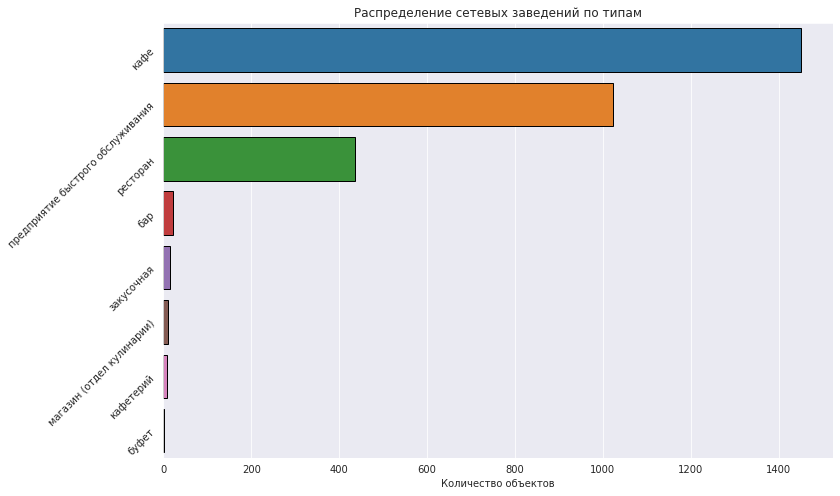

In [32]:
plt.figure(figsize=[12, 8]) #задаем размер фигуры
plt.yticks(rotation=45) #наклоняем подписи так, чтобы они читались, но занимали меньше места

chain_types_hist = sns.barplot(
    y='type',
    x='objects',
    data=chain_types,
    orient='h',
    edgecolor = "black",
)

chain_types_hist.set(
    title='Распределение сетевых заведений по типам', 
    xlabel='Количество объектов',
    ylabel=''
)

plt.show()

In [33]:
#соберем датафрейм, где сгруппируем заведения по типу и принадлежности к сети
data_grouped_by_chain_type = data.groupby(['object_type', 'chain'], as_index=False).agg({'address': 'count'})
data_grouped_by_chain_type.columns=['type', 'chain', 'objects']

In [34]:
#сформируем список, отсортированный по количеству объектов каждого типа для передачи функции построения графика
order = list(chain_types['type'])

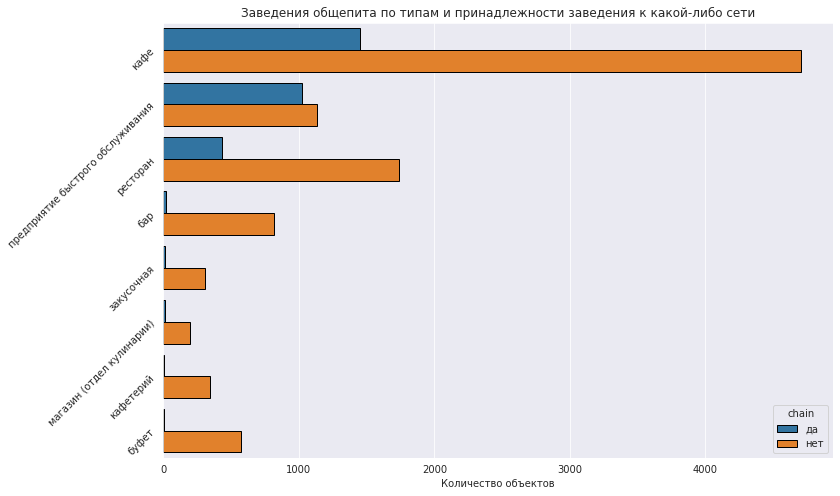

In [35]:
#построим гистограмму
plt.figure(figsize=[12, 8]) #задаем размер фигуры
plt.yticks(rotation=45) #наклоняем подписи так, чтобы они читались, но занимали меньше места

obj_by_by_chain_type = sns.barplot(
    x='objects',
    y='type',
    hue='chain',
    data=data_grouped_by_chain_type,
    orient='h', #ориентируем график горизонтально
    edgecolor = "black", #наносим на столбцы черные контурные линии
    order=order #упорядочим столбцы в соответствии с ранее сформированным списком
)

obj_by_by_chain_type.set(
    title='Заведения общепита по типам и принадлежности заведения к какой-либо сети', 
    xlabel='Количество объектов',
    ylabel=''
)

plt.show()

1. Наиболее распространенный тип сетевого заведения - кафе. Здесь мы наблюдаем чуть менее половины всех сетевых заведений выборки: около 1400/3000
2. Ниже примерно вдвое и втрое меньше по количеству следуют "предприятия быстрого обслуживнаия" и "рестораны" (примерно 800 и 550 заведений соответственно). Таким образом, порядка 90% сетевых заведений принадлежат к трем указанным категориям
3. Остальные 10% сетевых заведений приходятся на 6 оставшихся категорий
4. Количество сетевых заведений типа "буфет" и "столовая" исчезающе малы (11 и 6 соответственно) 

## Распределение количества мест в сетевых заведениях

In [36]:
chain_objects = data[data['chain'] == 'да']

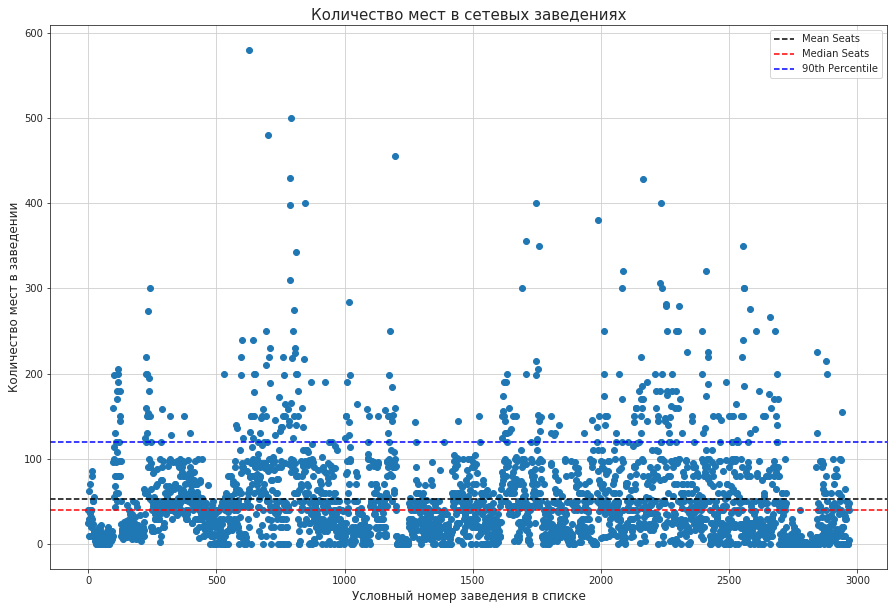

In [37]:
sns.set_style('ticks')

#построим диаграмму рассеяния
x_values = pd.Series(range(0, len(data[data['chain'] == 'да']['number'])))

plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Количество мест в сетевых заведениях', fontsize=15)

plt.scatter(x_values, data[data['chain'] == 'да']['number'])

plt.axhline(y=np.mean(data[data['chain'] == 'да']['number']), color='black', linestyle='--', label='Mean Seats')
plt.axhline(y=np.median(data[data['chain'] == 'да']['number']), color='red', linestyle='--', label='Median Seats')
plt.axhline(y=np.percentile(data[data['chain'] == 'да']['number'], 90), color='blue', linestyle='--', label='90th Percentile')

plt.xlabel('Условный номер заведения в списке', fontsize=12)
plt.ylabel('Количество мест в заведении', fontsize=12)

plt.legend()
plt.show()

На диаграмме мы видим следующее: 

1. 90% всех сетевых заведений имеют порядка 120 мест или менее
2. В среднем, в сетевом заведении порядка 50 мест
3. Различимость отдельных точек на графике теряется 

Однако мы можем посмотреть на данные под несколько другим углом. Ранее мы добавили в исходный датасет столбец с количеством объектов идентичного наименования - хоть картина и не получится полностью достоверной в виду ранее озвученной проблемы валидации наименований заведений, такая оценка позволит лучше понять, к чему тяготеют различные сетевые заведения. 

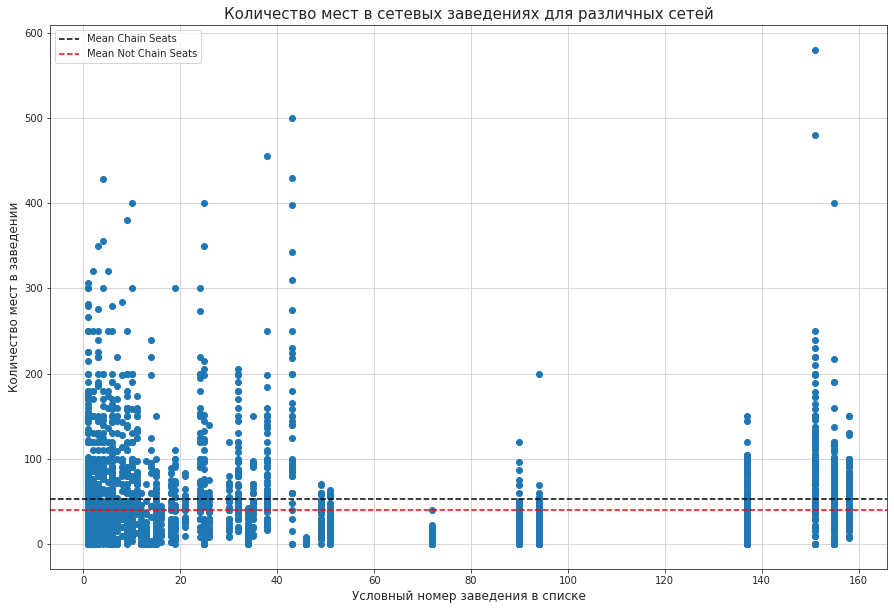

In [38]:
#в качестве значений для оси Х используем не сгенерированный диапазон значений, а количество объектов
x_values = data[data['chain'] == 'да']['same_name_objects']

plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Количество мест в сетевых заведениях для различных сетей', fontsize=15)
plt.ylim=(0, 300)

plt.scatter(x_values, data[data['chain'] == 'да']['number'])

plt.axhline(y=np.mean(data[data['chain'] == 'да']['number']), color='black', linestyle='--', label='Mean Chain Seats')
plt.axhline(y=np.median(data[data['chain'] == 'нет']['number']), color='red', linestyle='--', label='Mean Not Chain Seats')


plt.xlabel('Условный номер заведения в списке', fontsize=12)
plt.ylabel('Количество мест в заведении', fontsize=12)

plt.legend()
plt.show()

1. На графике наблюдается тренд на снижение выбросов по количеству мест при росте количества заведений в сети
2. Кроме того, среднее количество мест для сетевых заведений выше аналогичного значения для не сетевых заведений

Попробуем посмотреть на распределение мест в "топовых" по количеству объектов в сети.

In [39]:
top25_chains = data[data['chain'] == 'да'].groupby('object_name', as_index=False)\
.agg({'same_name_objects': 'max'}).sort_values(by='same_name_objects', ascending=False).head(25)

top25_chains = list(top25_chains['object_name'])

top25_chains_df = data[data['object_name'].isin(top25_chains)]

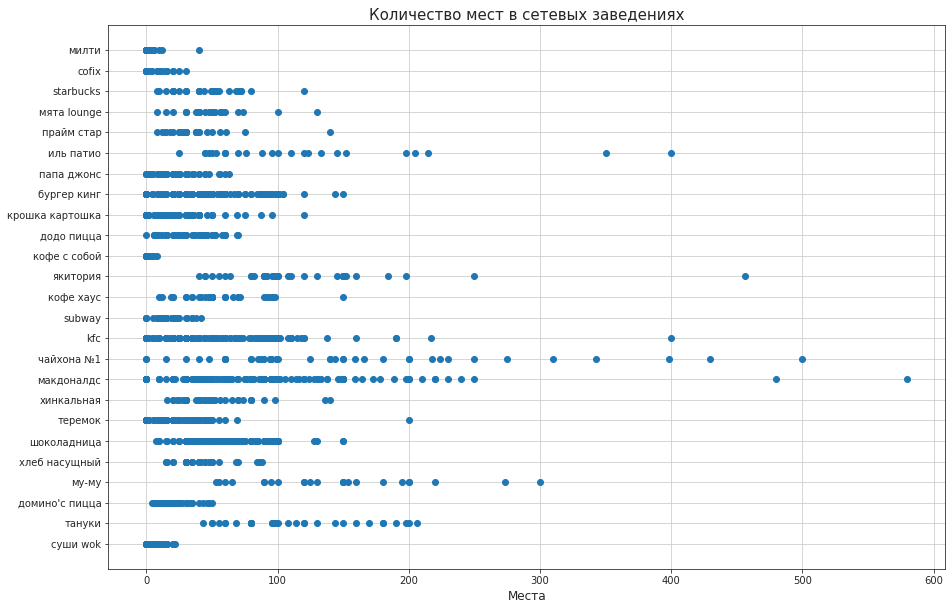

In [40]:
#построим диаграмму рассеяния для топа сетевых заведений 
x_values = top25_chains_df['number']

plt.figure(figsize=(15, 10))
plt.grid(axis='both')
plt.title('Количество мест в сетевых заведениях', fontsize=15)

plt.scatter(x_values, top25_chains_df['object_name'])

plt.xlabel('Места', fontsize=12)

plt.show()

In [41]:
print('Среднее количество мест в сетевом заведении:', np.mean(data[data['chain'] == 'да']['number']).astype('int'))

Среднее количество мест в сетевом заведении: 52


In [42]:
data['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Наблюдаем следующее: 

1. Сетевые заведения по количеству мест условно можно разделить на два типа: 
    + Заведения "жесткого" формата, у которых точки на оси Х практически сливаются в единую линию (зачастую, в диапазоне от 0 до 100 мест)
    + Заведения "мягкого" формата, у которых наблюдаются явные колебания по количеству мест. К таким, например, относится "Чайхона №1", у которой наблюдается относительно разреженное расположение точек от 0 до 500 мест. Возможно, эти заведения придерживаются более гибкой политики относительно вместимости заведений и потенциальной ЦА.
2. В целом, можно говорить о том, что сетевые заведения ориентации на обустройство относительно небольшого количества мест в 1 заведении сети.

## Распределение количества посадочных мест по типу заведения

In [43]:
#сформируем датасет, на базе которого построим график среднего количества мест в каждом типе заведения
seats_by_type = data.groupby('object_type', as_index=False).agg({'number': 'mean'}).sort_values(by='number', ascending=False)
seats_by_type['number'] = seats_by_type['number'].astype('int')

order = list(seats_by_type['object_type'])

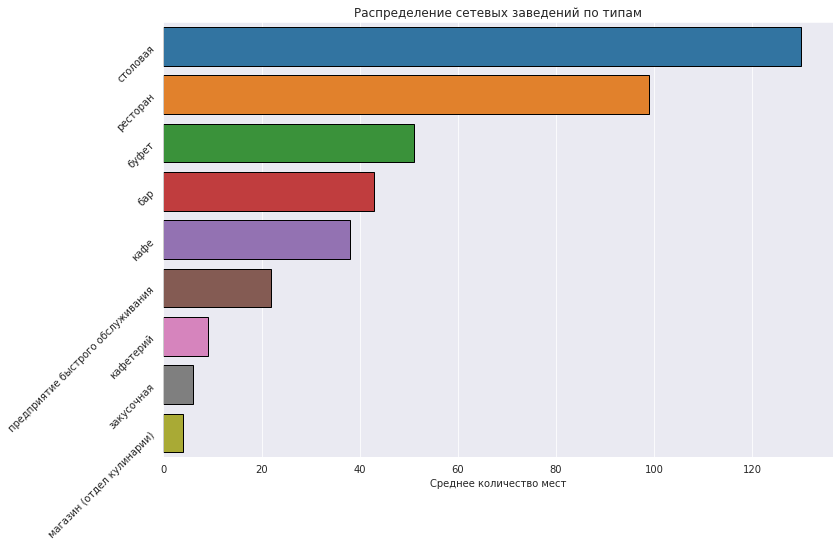

In [44]:
sns.set_style('darkgrid')

plt.figure(figsize=[12, 8]) 
plt.yticks(rotation=45)

chain_types_hist = sns.barplot(
    y='object_type',
    x='number',
    data=seats_by_type,
    orient='h',
    edgecolor = "black",
)

chain_types_hist.set(
    title='Распределение сетевых заведений по типам', 
    xlabel='Среднее количество мест',
    ylabel=''
)

plt.show()

In [45]:
#теперь оценим среднее количество в заведении каждого типа, но с учетом принадлежности заведения к сети
seats_by_type = data.groupby(['chain', 'object_type'], as_index=False).agg({'number': 'mean'}).sort_values(by='number', ascending=False)
seats_by_type['number'] = seats_by_type['number'].astype('int')

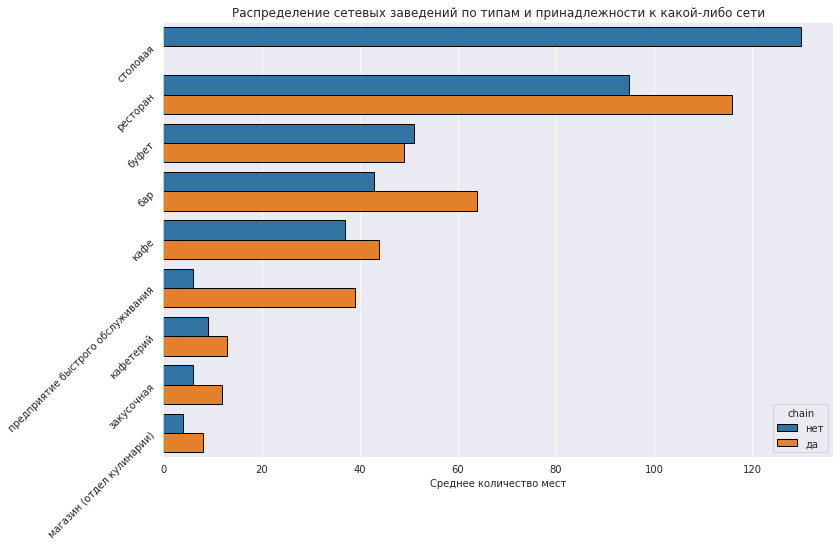

In [46]:
sns.set_style('darkgrid')

plt.figure(figsize=[12, 8]) 
plt.yticks(rotation=45)

chain_types_hist = sns.barplot(
    y='object_type',
    x='number',
    hue='chain',
    data=seats_by_type,
    orient='h',
    edgecolor = "black",
    order=order
)

chain_types_hist.set(
    title='Распределение сетевых заведений по типам и принадлежности к какой-либо сети', 
    xlabel='Среднее количество мест',
    ylabel=''
)

plt.show()

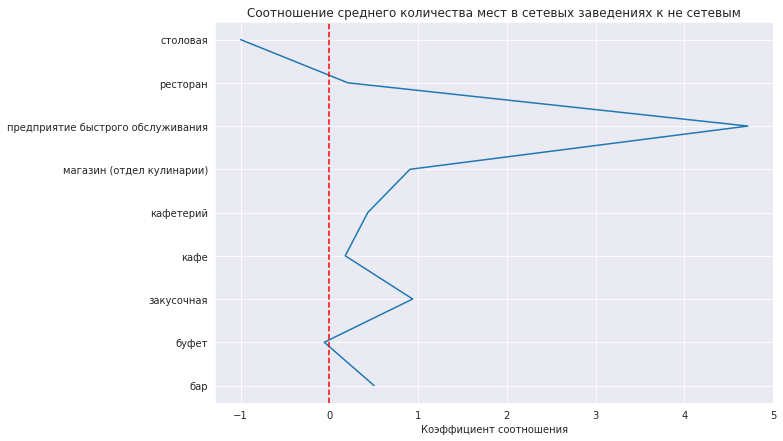

In [47]:
mean_seats_comparison = data.pivot_table(index='object_type', values='number', columns='chain', aggfunc='mean').reset_index().fillna(0)
mean_seats_comparison.columns=['type', 'mean_chain', 'mean_not_chain']
mean_seats_comparison['comparison'] = (mean_seats_comparison['mean_chain'] / mean_seats_comparison['mean_not_chain']) - 1

plt.figure(figsize=(10, 7))
plt.plot(mean_seats_comparison['comparison'], mean_seats_comparison['type'])
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Соотношение среднего количества мест в сетевых заведениях к не сетевым', fontsize=12)
plt.xlabel('Коэффициент соотношения', fontsize=10)

plt.show()

1. Наибольшее среднее количество мест в столовых - порядка 130 на 1 объект
2. Второй тип заведения по количеству мест - ресторан. В таких заведениях, с среднем, порядка 100 мест
3. Буфет и бар в среднем отличаются как минимум вдвое от ресторана: в них около 50 и 40 мест
4. В наиболее популярном типе заведения (кафе) среднее количество мест также находится в районе отметки в 40 мест
5. Во всех типах заведений среднее количество мест в сетевых заведениях больше, чем в не сетевых: 
    + Столовые - не сетевой тип заведения
    + Буфет - единственный тип заведения, где среднее количество мест в сетевых заведения меньше (49 в сетевых заведениях и 52 в индивидуальных), хотя разница не слишком существенна - порядка 5.7%
    + Отделы кулинарии в сетевых магазинах и сетевые закусочные имеют на 91% и 94% больше мест, чем аналогичные не сетевые заведения (8.3 и 12.3 против 4.3 и 6.4 соответственно) 
    + Наиболее интересное наблюжение - это большее в 4.7 раза среднее количество мест в сетевых приприятиях быстрого обслуживания

## Разбор адресов объектов (столбец `address`)

In [48]:
data.head(10)

,id,object_name,chain,object_type,address,number,same_name_objects
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,1
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,1
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,1
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,2
4,135770,пиццетория,да,кафе,"город Москва, Дубнинская улица, дом 53, корпус 1",25,2
5,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,1
6,27429,стол. при гоу сош № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240,1
7,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,8
8,111162,брусника,да,кафе,"город Москва, проспект Мира, дом 49",40,8
9,77314,брусника,да,кафе,"город Москва, улица Маросейка, дом 6-8, строение 1",62,8


Мы видим, что запись адреса производится через стандартизированный разделитель - запятую. Однако, в некоторых строках запятых две (когда указан только конкретный дом), а в некоторых три (когда адрес детализируется до корпуса конкретного дома на улице).

Таким образом, нам необходимо разделить строку

In [49]:
def address_parser(row): 
    adr = list(row['address'].split(', ')) #бъем строку на части по сепаратору ", "
    if len(adr) < 3:
        if 'город ' in adr[0]:
            row['city'] = adr[0]
            row['street_name'] = adr[1]
        else:
            row['city'] = 'город Москва'
            row['street_name'] = adr[0]
            row['building'] = adr[1]
    elif len(adr) == 3: #если длина полученного списка равна 3, то идем ниже по алгоритму
        if 'город ' in adr[1]: #проверяем на записи с двумя городами в строке, если да, то
            row['city'] = adr[1] #городом будет второе значение в списке (например, Троицк)
            row['street_name'] = adr[1]
            row['building'] = adr[2] #наименования улицы не будет - сразу же запишем номер здания
        elif 'город ' in adr[0]: #если длина корректная, то тут запись простая
            row['city'] = adr[0]
            row['street_name'] = adr[1]
            row['building'] = adr[2]
        else:
            row['city'] = 'город Москва'
            row['street_name'] = adr[0]
            row['building'] = adr[1] + ', ' + adr[2]
    elif len(adr) > 3: #если длина полученного списка равна 4, то идем ниже по алгоритму. Ниже по аналогии с 3 элементами
        if 'город ' in adr[1]:
            row['city'] = adr[1]
            row['street_name'] = adr[2]
            row['building'] = adr[3]
        elif 'город ' in adr[0]:
            row['city'] = adr[0]
            if 'улица' in adr[2]: #отдельно обработаем случаи, когда улица в третьем элементе списка 
                row['street_name'] = adr[2]
                row['building'] = adr[3]
            else:
                row['street_name'] = adr[1]
                row['building'] = adr[2] + ', ' + adr[3] #только в номер дома будем писать два значения, склеивая их
        else:
            row['city'] = 'город Москва'
            row['street_name'] = adr[0]
            row['building'] = adr[1] + ', ' + adr[2] + ', ' + adr[3]
    return row

In [50]:
#экспериментальным путем установлено, что функция выполняется примерно на 90% быстрее при создании столбцов до запуска функции
#вероятно, создание ячейки внутри функции требует вызова какой-то внешней функции/метода панд и так для каждой строки
data['city'] = np.nan
data['street_name'] = np.nan
data['building'] = np.nan

#применим функцию
data = data.apply(address_parser, axis=1)

In [51]:
#посмотрим на полученный результат
data.sample(5)

,id,object_name,chain,object_type,address,number,same_name_objects,city,street_name,building
10734,26916,октоберфест,нет,кафе,"город Москва, улица Земляной Вал, дом 7, строение 1",40,1,город Москва,улица Земляной Вал,"дом 7, строение 1"
8436,22207,кафе «маяк»,нет,кафе,"город Москва, Звёздный бульвар, дом 17, строение 3",40,1,город Москва,Звёздный бульвар,"дом 17, строение 3"
663,137060,хлеб насущный,да,кафе,"город Москва, Павелецкая площадь, дом 2, строение 3",40,32,город Москва,Павелецкая площадь,"дом 2, строение 3"
2126,154360,"шаурма, выпечка",нет,предприятие быстрого обслуживания,"город Москва, Новогиреевская улица, дом 20/34, корпус 1",0,13,город Москва,Новогиреевская улица,"дом 20/34, корпус 1"
10379,146487,корона,нет,кафе,"город Москва, 1-я Рейсовая улица, дом 6-А",70,1,город Москва,1-я Рейсовая улица,дом 6-А


## Топ-10 улиц по количеству объектов общественного питания

In [52]:
#так как в процессе решения текущей задачи нам потребуются данные по району каждого заведения, импортируем в проект данные
spreadsheet_id = '1vGzkxEv624i3SFnP0LRHISDb1cIaUKAmJrwFTfp-e1E'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
streets_neighbourhoods = pd.read_csv(BytesIO(r.content))
streets_neighbourhoods.sample(3)

,ID,Name,global_id,IsNetObject,OperatingCompany,TypeObject,AdmArea,District,Address,PublicPhone,SeatsCount,SocialPrivileges,Longitude_WGS84,Latitude_WGS84,geodata_center,geoarea
2272,29218,СТОЛ. ПРИ ШК. 1370,637528718,нет,NaN,столовая,Северо-Восточный административный округ,Алтуфьевский район,"город Москва, Костромская улица, дом 14Г, строение 1",PublicPhone:(499) 901-21-22\n\n,240,да,37.595954,55.884350,010100000045DCA23948CC42409BC0DC5E32F14B40,NaN
15033,284907,Бар Бочка,1075020327,нет,NaN,бар,Южный административный округ,район Царицыно,"город Москва, Пролетарский проспект, дом 14/49, корпус 1",PublicPhone:нет телефона\n\n,10,нет,37.654451,55.636768,0101000000F32E220CC5D34240E166089F81D14B40,NaN
14063,279667,Хинкальная «Батуми»,1061825256,нет,NaN,кафе,Юго-Западный административный округ,район Тёплый Стан,"город Москва, Ленинский проспект, дом 123В",PublicPhone:нет телефона\n\n,24,нет,37.481176,55.647789,010100000060CFD72C97BD4240C6C1B0BDEAD24B40,NaN


In [53]:
place_neighbourhood = streets_neighbourhoods[['Name', 'Address', 'AdmArea', 'District']] #сохраним нужные данные в датафрейм
place_neighbourhood.columns=['object_name', 'address', 'AdmArea', 'District'] #синхронизируем имена столбцов с основным файлом
place_neighbourhood['object_name'] = place_neighbourhood['object_name'].str.lower() #по аналогии с data приведем наименования 
#к нижнему регистру
data = data.merge(place_neighbourhood, on='address', how='left').drop_duplicates('id') #сливаем районы с основным датафреймом
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,object_name_x,chain,object_type,address,number,same_name_objects,city,street_name,building,object_name_y,AdmArea,District
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,1,город Москва,улица Егора Абакумова,дом 9,сметана,Северо-Восточный административный округ,Ярославский район
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,1,город Москва,улица Талалихина,"дом 2/1, корпус 1",родник,Центральный административный округ,Таганский район
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,1,город Москва,Абельмановская улица,дом 6,кафе «академия»,Центральный административный округ,Таганский район
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,2,город Москва,Абрамцевская улица,дом 1,"шашлыки, выпечка, шаурма",Северо-Восточный административный округ,район Лианозово
5,135770,пиццетория,да,кафе,"город Москва, Дубнинская улица, дом 53, корпус 1",25,2,город Москва,Дубнинская улица,"дом 53, корпус 1",пиццетория,Северный административный округ,Бескудниковский район


Так как из предыдущей таблицы нам удалось данные по району для 13481 из 15366 строк (то есть, для 87.7% записей), мы попробуем получить дополнительные данные из еще одного внешнего источника.

In [54]:
url = 'http://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv' #по ссылке лежит файл с районами
req = requests.get(url) #делаем запрос по урле
req.encoding = 'utf-8' #меняем кодировку ответа
streets_ngbhds = pd.read_csv(io.StringIO(req.text)) #при помощи библиотеки ввода-вывода читаем строку из текста запроса и 
#превращаем ее в датафрейм методом чтения из файла *.csv

In [55]:
#сформируем датафрейм, в котором сохраним районы
streets_ngbhds = streets_ngbhds.groupby('streetname', as_index=False).agg({'area': 'max'})
streets_ngbhds.columns=['street_name', 'district_mosgaz'] 
streets_ngbhds.head()

,street_name,district_mosgaz
0,1-й Автозаводский проезд,Даниловский район
1,1-й Амбулаторный проезд,Район Аэропорт
2,1-й Архивный переулок,Район Хамовники
3,1-й Бабьегородский переулок,Район Якиманка
4,1-й Балтийский переулок,Район Аэропорт


In [56]:
data = data.merge(streets_ngbhds, on='street_name', how='left').drop_duplicates('id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 14 columns):
id                   15366 non-null int64
object_name_x        15366 non-null object
chain                15366 non-null object
object_type          15366 non-null object
address              15366 non-null object
number               15366 non-null int64
same_name_objects    15366 non-null int64
city                 15366 non-null object
street_name          15366 non-null object
building             15366 non-null object
object_name_y        13481 non-null object
AdmArea              13481 non-null object
District             13481 non-null object
district_mosgaz      14617 non-null object
dtypes: int64(3), object(11)
memory usage: 1.8+ MB


Далее проверим заполненность столбцов сета данных, полученных из разных внешних источников.

In [57]:
#для простоты обработки значения NaN в датасете заполним строкой 'No Data'
data['District'] = data['District'].fillna('No Data')
data['district_mosgaz'] = data['district_mosgaz'].fillna('No Data')

In [58]:
#функцией заполнение пустые значения района из второго внешнего источника данных
def district_comp(row):
    if row['District'] == 'No Data' and row['district_mosgaz'] == 'No Data':
        row['District'] = 'Новая Москва'
    elif row['District'] == 'No Data':
        row['District'] = row['district_mosgaz']
    else:
        row['District'] = row['District']
    return row

Так как оставшиеся заведения (около 160) относятся к различным поселениям и удаленным городам московской агломерации, мы присвоим им всем значение "Новая Москва". В любом случае, этой информации будет достаточно для понимания, где находятся такие заведения общепита.

In [59]:
data = data.apply(district_comp, axis=1)

In [60]:
del data['object_name_y']
del data['AdmArea']
del data['district_mosgaz']
data.sample(5)

,id,object_name_x,chain,object_type,address,number,same_name_objects,city,street_name,building,District
5761,80910,укубар,нет,кафе,"город Москва, улица Покровка, дом 17, строение 1",10,1,город Москва,улица Покровка,"дом 17, строение 1",Басманный район
14522,220957,chicken duck,нет,кафе,"город Москва, улица Вавилова, дом 64/1, строение 1",8,2,город Москва,улица Вавилова,"дом 64/1, строение 1",Гагаринский район
12969,173195,паб,нет,бар,"город Москва, Щербаковская улица, дом 53, корпус 15",10,2,город Москва,Щербаковская улица,"дом 53, корпус 15",район Соколиная Гора
14823,223281,ресторан ип кантария,нет,кафе,"город Москва, улица Миклухо-Маклая, дом 36А",5,1,город Москва,улица Миклухо-Маклая,дом 36А,район Коньково
6549,20927,столовая при бизнес-колледже,нет,столовая,"город Москва, Ботаническая улица, дом 21",32,1,город Москва,Ботаническая улица,дом 21,район Марфино


In [61]:
#исключим их топа улиц те локации, которые лежат за пределами МКАД, так как вряд ли мы будем рассматривать открытие 
#инновационного заведения далеко от центра
top10_streets = data[np.logical_not(data['street_name'].isin(['город Зеленоград', 'поселение Сосенское']))]\
.groupby('street_name', as_index=False).agg({'id': 'count'}).sort_values(by='id', ascending=False).head(10)

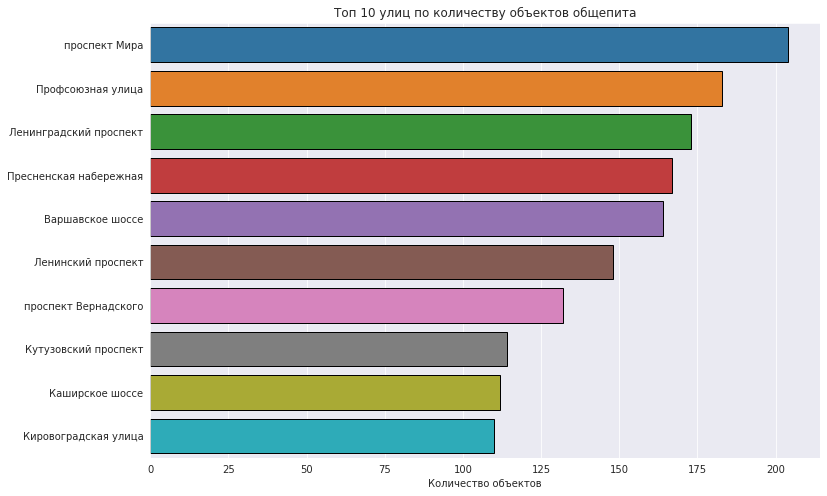

In [62]:
plt.figure(figsize=[12, 8])

chain_types_hist = sns.barplot(
    x='id',
    y='street_name',
    orient='h',
    data=top10_streets,
    edgecolor = "black",
)

chain_types_hist.set(
    title='Топ 10 улиц по количеству объектов общепита', 
    xlabel='Количество объектов',
    ylabel=''
)

plt.show()

In [63]:
#сформируем пул районов для топ10 улиц 
top10_districts_df = data[data['street_name'].isin(top10_streets['street_name'])]
top10_districts_df = top10_districts_df.groupby('District', as_index=False).agg({'id': 'count'}).sort_values(by='id', ascending=False)

In [64]:
#в итоге мы получаем датафрейм со списком районов, в которых находятся объекты топ10 улиц 
top10_districts_df.head()

,District,id
9,Пресненский район,167
40,район Чертаново Центральное,89
36,район Тропарёво-Никулино,80
23,район Аэропорт,64
34,район Свиблово,62


In [65]:
mean = data.groupby('District', as_index=False).agg({'id': 'count'})['id'].mean().astype('int')
median = data.groupby('District', as_index=False).agg({'id': 'count'})['id'].median().astype('int')

print(mean)
print(median)

63
35


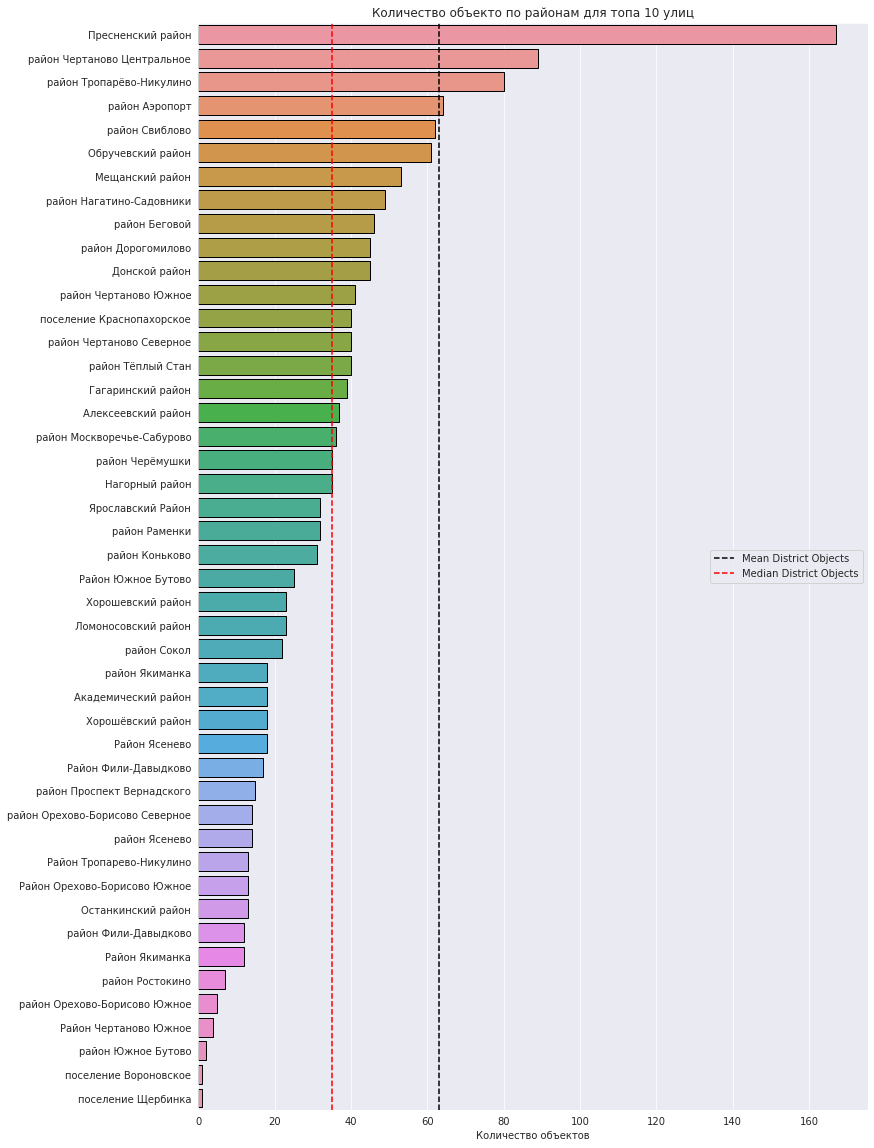

In [66]:
plt.figure(figsize=[12, 20])

chain_types_hist = sns.barplot(
    x='id',
    y='District',
    orient='h',
    data=top10_districts_df,
    edgecolor = "black",
)

plt.axvline(x=data.groupby('District', as_index=False).agg({'id': 'count'})['id'].mean().astype('int'), color='black', linestyle='--', label='Mean District Objects')
plt.axvline(x=data.groupby('District', as_index=False).agg({'id': 'count'})['id'].median().astype('int'), color='red', linestyle='--', label='Median District Objects')

chain_types_hist.set(
    title='Количество объекто по районам для топа 10 улиц', 
    xlabel='Количество объектов',
    ylabel=''
)

plt.legend(loc='right')
plt.show()

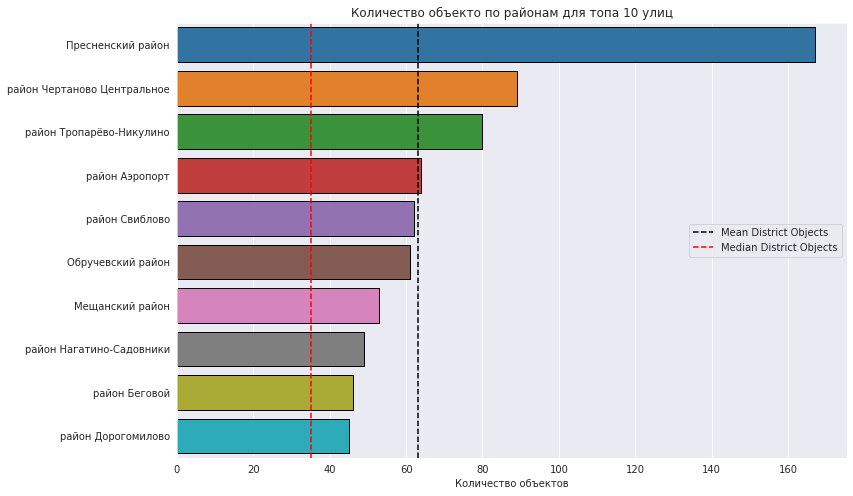

In [67]:
plt.figure(figsize=[12, 8])

chain_types_hist = sns.barplot(
    x='id',
    y='District',
    orient='h',
    data=top10_districts_df.head(10),
    edgecolor = "black",
)

plt.axvline(x=data.groupby('District', as_index=False).agg({'id': 'count'})['id'].mean().astype('int'), color='black', linestyle='--', label='Mean District Objects')
plt.axvline(x=data.groupby('District', as_index=False).agg({'id': 'count'})['id'].median().astype('int'), color='red', linestyle='--', label='Median District Objects')

chain_types_hist.set(
    title='Количество объекто по районам для топа 10 улиц', 
    xlabel='Количество объектов',
    ylabel=''
)

plt.legend(loc='right')
plt.show()

Мы видим, что в списке топ10 улиц по количеству объектов находятся те, что располагаются в центральной части города и те, что располагаются одновременно в разных районах города.

## Улицы с 1 объектом общественного питания

In [68]:
#соберем датафрейм, в котором зафиксируем районе, к которым принадлежат улицы с 1 объектом общепита из исходных данных
streets_one_object = data.groupby('street_name', as_index=False).agg({'id': 'count'})
streets_one_object = streets_one_object[streets_one_object['id'] == 1]
one_object_districts = data[data['street_name'].isin(streets_one_object['street_name'])]
one_object_districts = one_object_districts.groupby('District', as_index=False).agg({'id': 'count'}).sort_values(by='id', ascending=False)

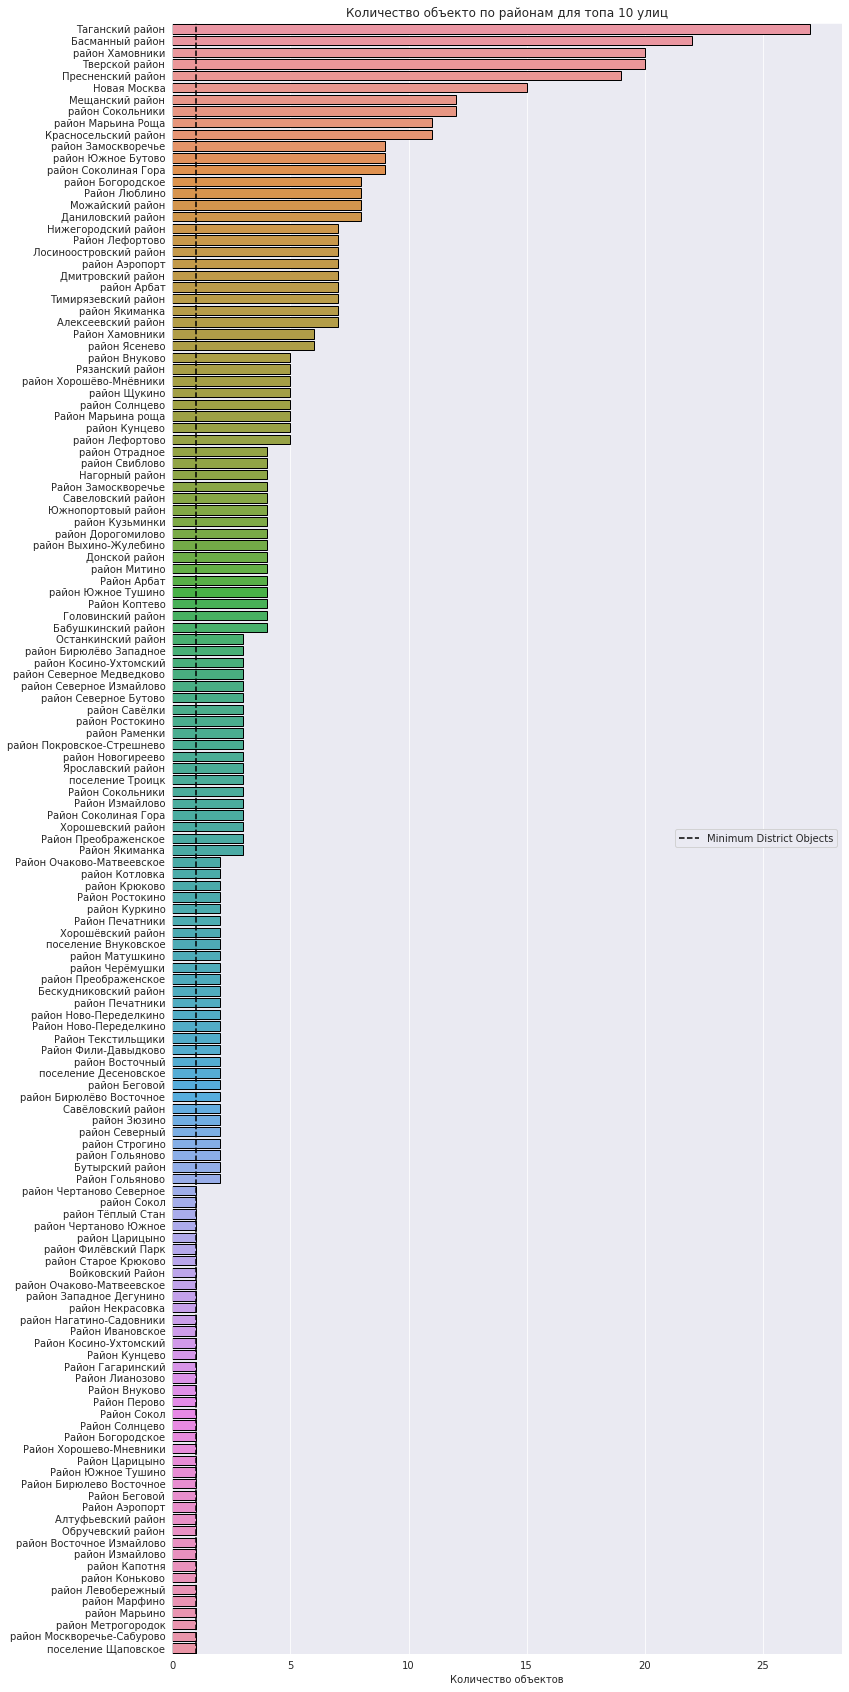

In [69]:
plt.figure(figsize=[12, 30])

chain_types_hist = sns.barplot(
    x='id',
    y='District',
    orient='h',
    data=one_object_districts,
    edgecolor = "black",
)

plt.axvline(x=data.groupby('District', as_index=False).agg({'id': 'count'})['id'].min().astype('int'), color='black', linestyle='--', label='Minimum District Objects')

chain_types_hist.set(
    title='Количество объекто по районам для топа 10 улиц', 
    xlabel='Количество объектов',
    ylabel=''
)

plt.legend(loc='right')
plt.show()

## Анализ распределения посадочных мест в заведения на топ 10 улицах по количеству заведений

Улицами с большим количеством заведений общественного питания мы будем считать те, что хранятся в переменной top10_streets, которую мы создали ранее.

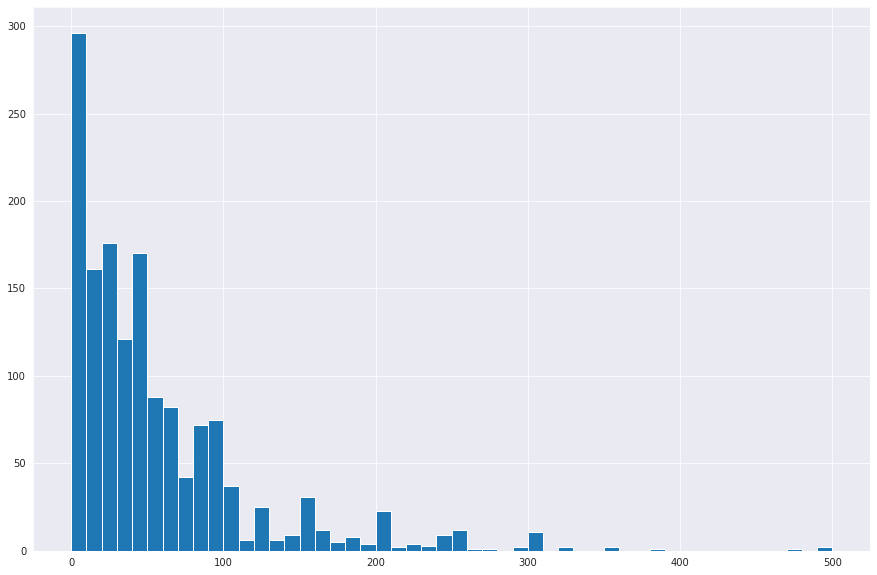

In [70]:
#построим диаграмму распределения заведений по количеству посадочных мест в них
top10_streets_df = data[data['street_name'].isin(top10_streets['street_name'])]
top10_streets_df['number'].hist(bins=50, figsize=(15, 10), range=(0, 500))

1. Большая часть заведений расположилась в диапазоне от 0 до 100 посадочных мест
2. Самый популярный формат - это 0-10 посадочных мест. Вероятно, речь о заведения вообще без посадочных мест (например, заведения в формате "окна"), либо о заведениях с номинальными посадочными местами. Мы можем предположить, что у таких заведений ниже средний чек, но более высокая проходимость
3. На "втором месте" заведения с количеством посадочных мест в диапазоне 10-50 посадочных мест. Это, вероятно, также небольшие заведения, но уже более продвинутого формата. 

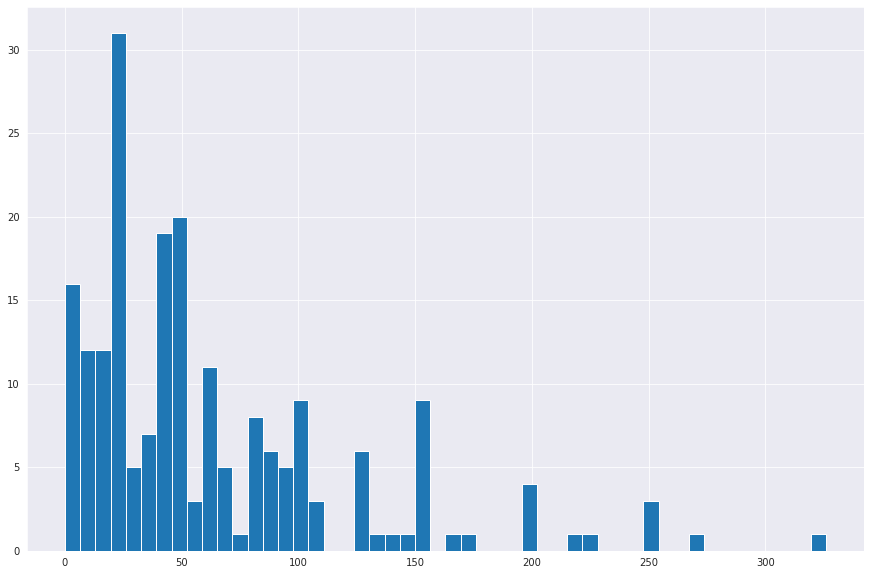

In [71]:
data[data['street_name'] == 'проспект Мира']['number'].hist(bins=50, figsize=(15, 10))

In [72]:
#напишем функцию для построения диаграммы рассеяния, которую ниже мы используем для построения нескольких графиков

def scatter_graph_draw(df, street_name):
    sns.set_style('ticks') #задаем стиль диаграммы
    
    #делаем список числовых значений на основе данных столбца chain
    colidx=df[df['street_name'] == street_name]\
    .groupby("chain").grouper.group_info[0].tolist() 
    
    colors=['red', 'green'] #точки, обозначающие заведения, покрасим в два цвета: красный и зеленый

    x_values = pd.Series(
        range(0, len(df[df['street_name'] == street_name]['number']))
    ) #значения по оси Х - это список чисел от 0 до длины датафрейма

    plt.figure(figsize=(15, 10))
    plt.grid(axis='both')
    #склеим наименование из графика
    plt.title(('Места в заведениях на ' + street_name + ' (красный - сетевое заведение, зеленый - обычное)'), fontsize=15)

    #строим график 
    plt.scatter(x_values,
                df[df['street_name'] == street_name]['number'],
                c=[colors[x] for x in colidx])

    #добавляем горизонтальные пунктирные линии для среднего, медианы и 95го перцентиля
    plt.axhline(y=np.mean(df[df['street_name'] == street_name]['number']), color='black', linestyle='--', label='Mean Seats')
    plt.axhline(y=np.median(df[df['street_name'] == street_name]['number']), color='red', linestyle='--', label='Median Seats')
    plt.axhline(y=np.percentile(df[df['street_name'] == street_name]['number'], 95), color='blue', linestyle='--', label='95th Percentile')

    plt.xlabel('Условный номер заведения в списке', fontsize=12)
    plt.ylabel('Количество мест в заведении', fontsize=12)

    plt.legend()
    plt.show()

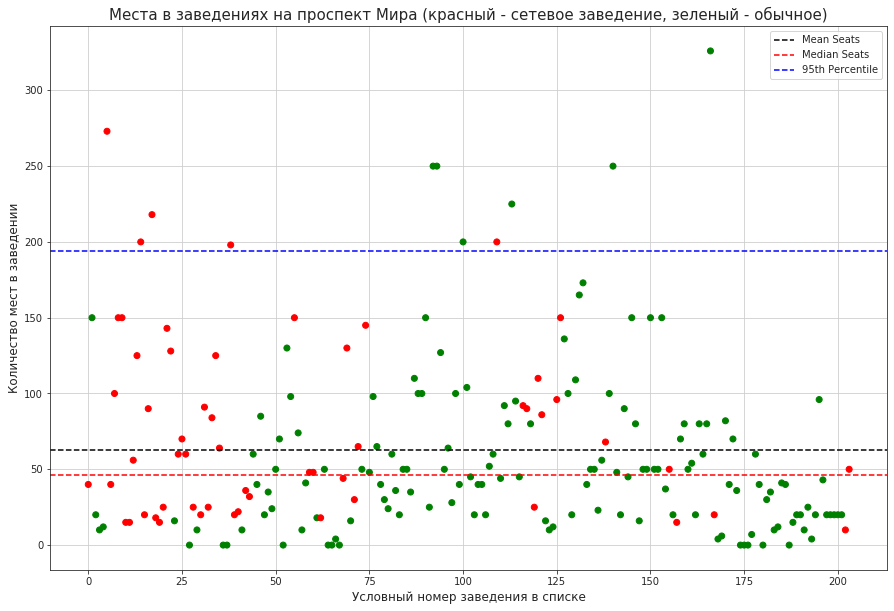

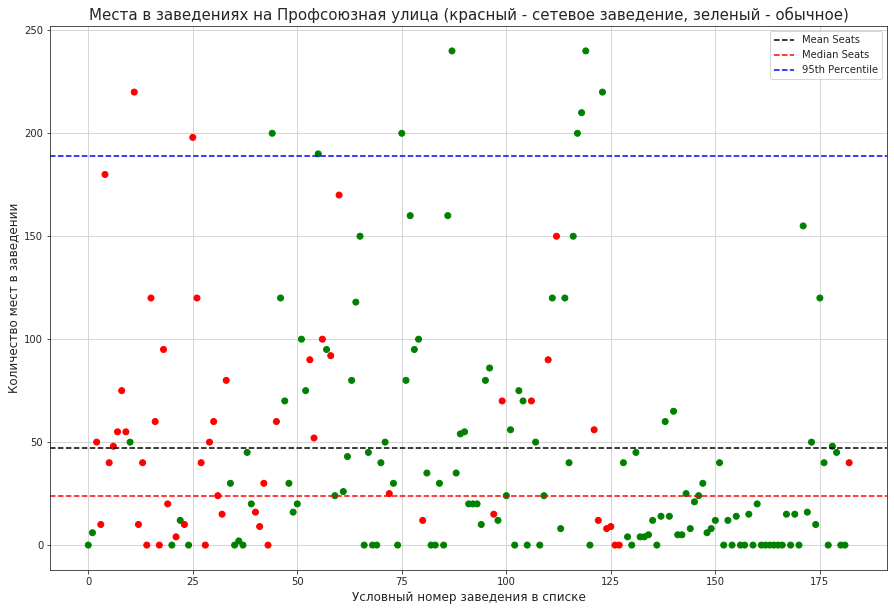

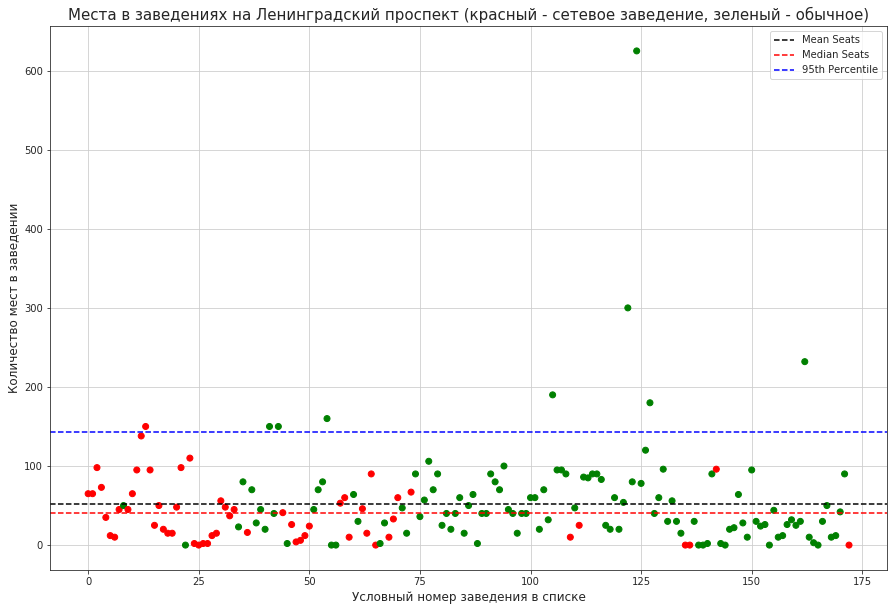

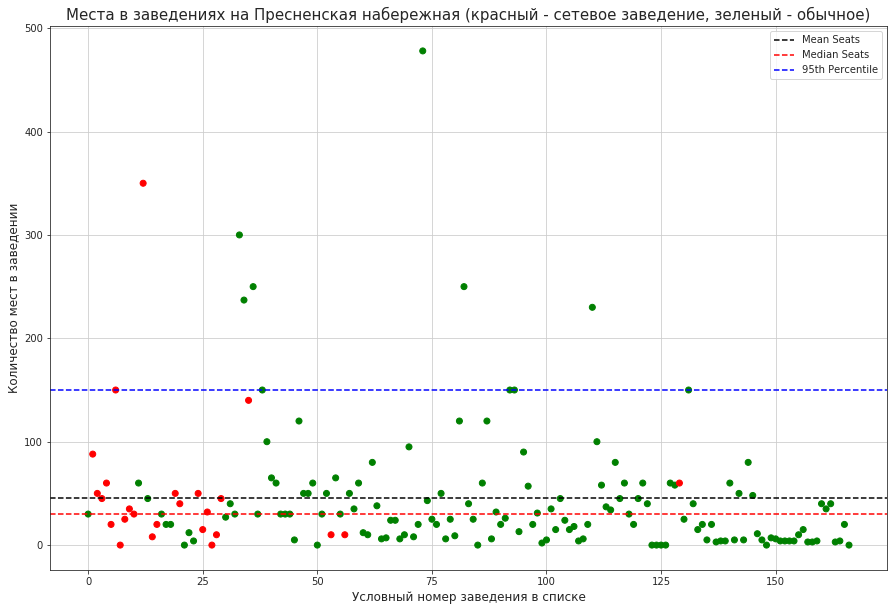

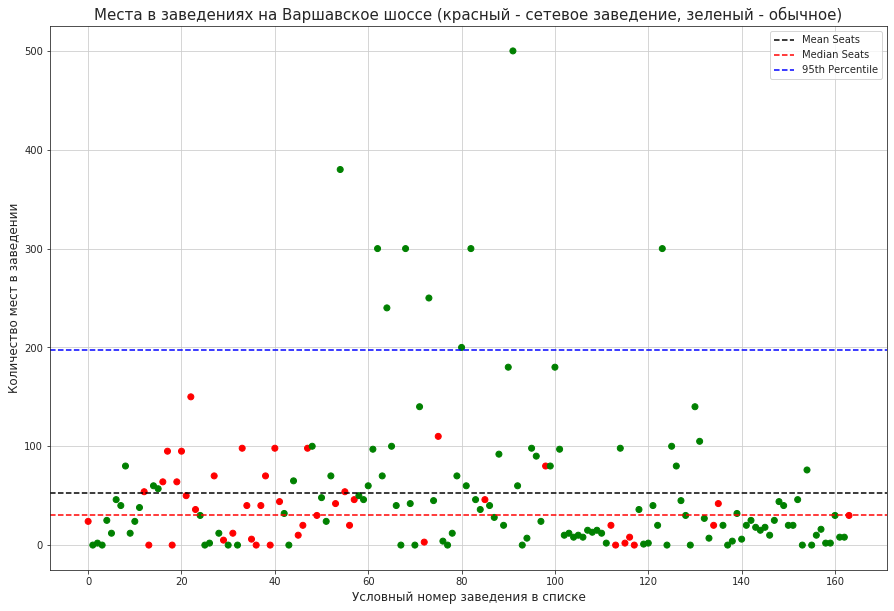

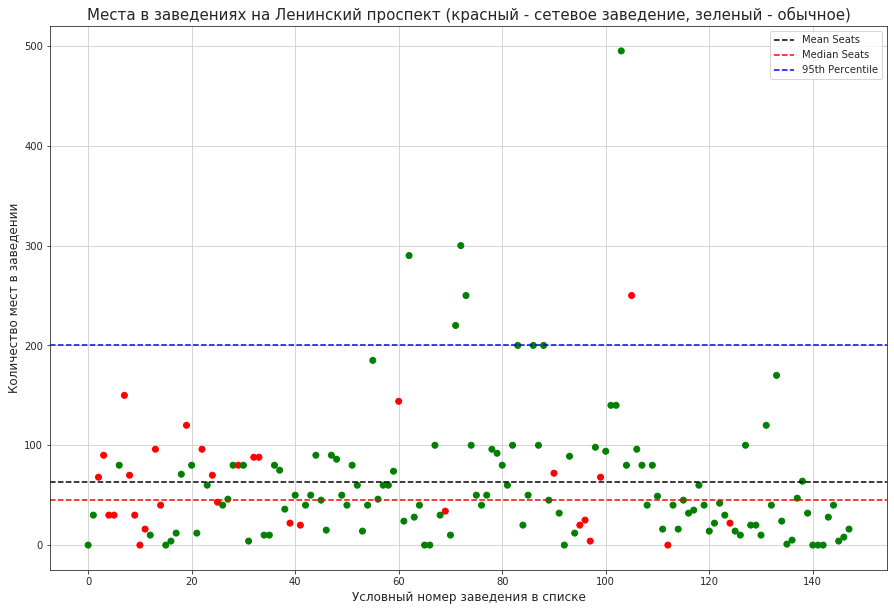

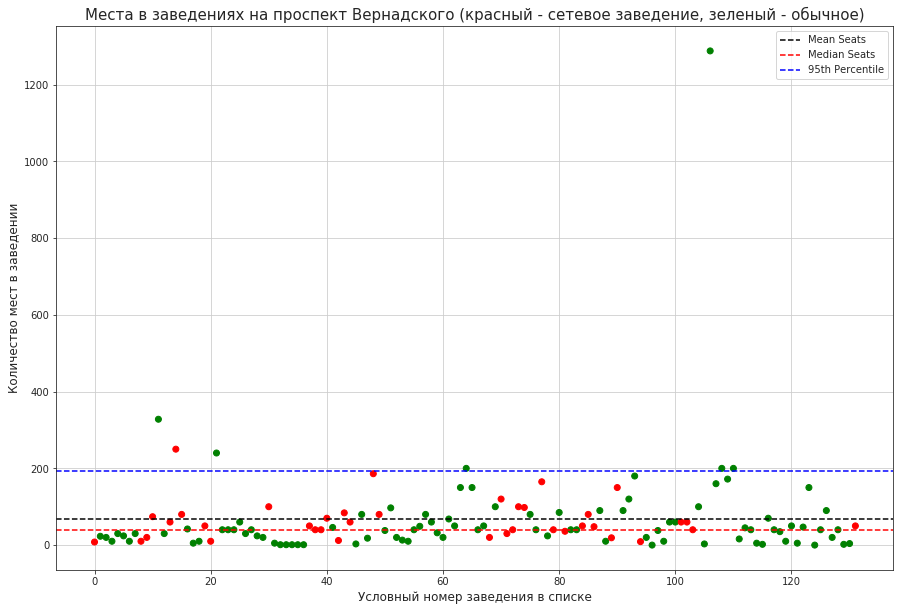

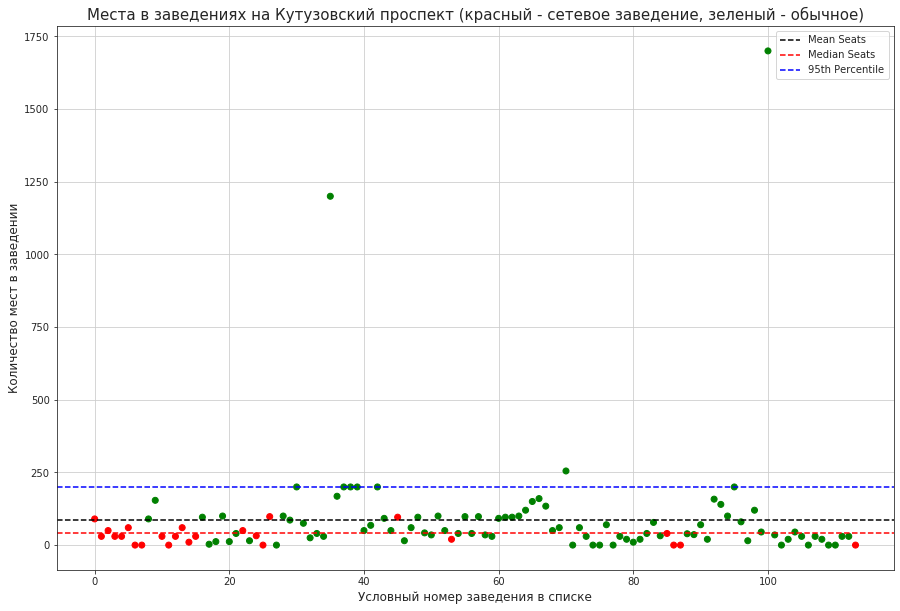

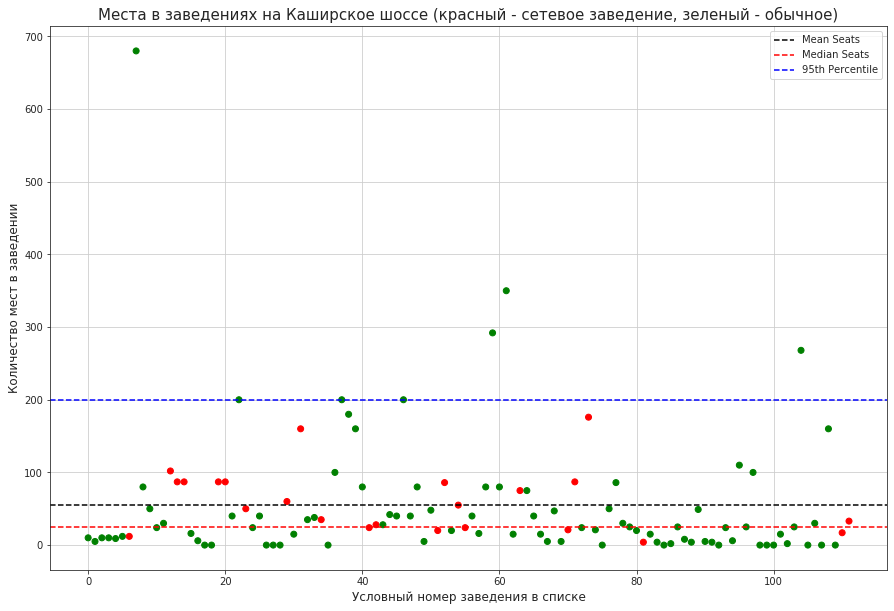

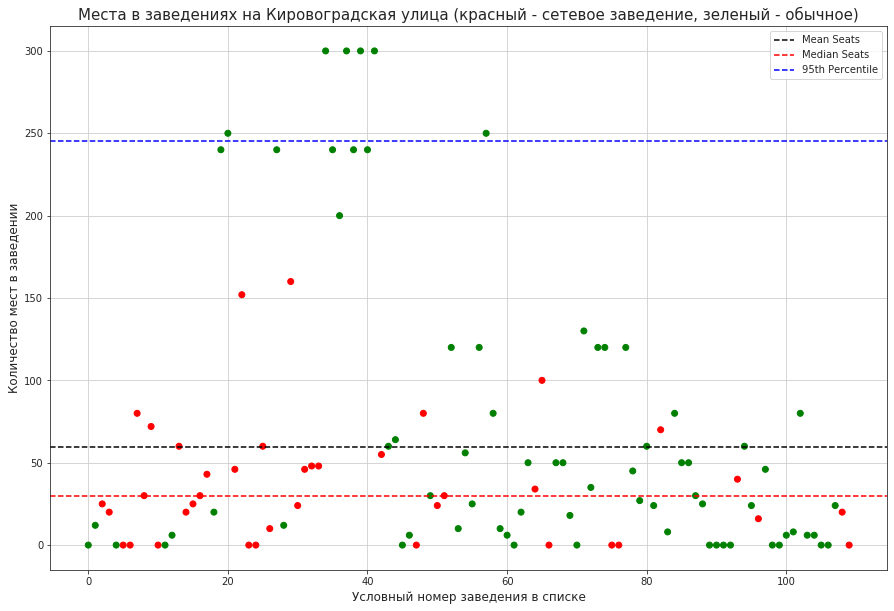

In [73]:
#положим нашу функцию в цикл и построим диаграмму для каждой улицы из списка топ 10 улиц
for i in top10_streets['street_name']:
    scatter_graph_draw(top10_streets_df, i)

In [74]:
#также оценим количество заведений по районам улиц
data[data['street_name'].isin(top10_streets['street_name'])
    ].groupby(['street_name', 'District'], as_index=False
             ).agg({'id': 'count', 'number': 'mean'}).sort_values(by='id', ascending=False).round(1).head(10)

,street_name,District,id,number
36,Пресненская набережная,Пресненский район,167,45.8
16,Кировоградская улица,район Чертаново Центральное,78,48.3
24,Ленинградский проспект,район Аэропорт,64,46.2
55,проспект Мира,район Свиблово,62,67.6
49,проспект Вернадского,район Тропарёво-Никулино,60,64.3
51,проспект Мира,Мещанский район,53,55.6
25,Ленинградский проспект,район Беговой,46,66.1
20,Кутузовский проспект,район Дорогомилово,45,144.4
11,Каширское шоссе,район Нагатино-Садовники,44,46.8
19,Кутузовский проспект,поселение Краснопахорское,40,23.0


In [75]:
#и такой же расчет для типа заведения - кафе
data[
    (data['object_type'] == 'кафе') & (data['street_name'].isin(top10_streets['street_name']))
].groupby(['street_name', 'District'], as_index=False
         ).agg({'id': 'count', 'number': 'mean'}).sort_values(by='id', ascending=False).round(1).head(10)

,street_name,District,id,number
35,Пресненская набережная,Пресненский район,96,35.6
54,проспект Мира,район Свиблово,38,79.4
50,проспект Мира,Мещанский район,28,46.7
23,Ленинградский проспект,район Аэропорт,25,41.0
40,Профсоюзная улица,район Тёплый Стан,23,32.1
18,Кутузовский проспект,поселение Краснопахорское,22,18.7
48,проспект Вернадского,район Тропарёво-Никулино,22,37.2
0,Варшавское шоссе,Донской район,21,46.0
26,Ленинский проспект,Гагаринский район,19,39.3
52,проспект Мира,Ярославский Район,17,51.6


1. Чем меньше на улице объектов общественного питания, тем уже диапазон, в котором лежат "традиционные" значения количества мест: например, на проспекте Мира мы наблюдаем относительно плотное расположение точек примерно до 150 мест, по мере движения к концу списка топовых улиц мы видим смещение среднего значения и смещения области плотного расположения точек до отметок в 50-100 мест (в зависимости от улицы)
2. На всех улицах кроме проспекта Мира и Профсоюзной улицы сетевые заведения довольно сильно стандартизированы: количество мест в них обычно не превышает 100 (зачастую ниже). При этом, почти на каждой улице наблюдаются несколько объектов-выбросов. В некоторых случаях количество мест в таких объектах превышает 1000 и такие заведения всегда являются не сетевыми
3. Почти на всех улицах и медианное и среднее значение лежат у отметки в 50 посадочных мест. При этом, в многих случаях диапазон между этими двумя значениями вызван смещением среднего вверх по оси Y за счет "мощных" выбросов. 

# Выводы и рекомендации

1. В топе типов объектов общепита по количеству заведений: кафе, предприятие быстрого питания, ресторан, столовая и бар. Из перечисленных вариантов, для формата заведения с роботами в качестве официантов подходят три: ресторан, кафе и бар (очень условно, так как зависит от формата заведения). Следовательно, выбор типа заведения необходимо произвести из следующих вариантов: 
    + Ресторан 
    + Кафе
    + Бар
2. Судя по анализу количества мест в заведениях на разных улицах, наиболее распространный формат заведения по местам лежит вокруг значение в 50 мест. Таким образом, не рекомендуется проектировать заведение с количеством мест более 50. 
3. Если мы оценим вопрос выбора типа заведения по количеству мест, то наиболее предпочтительным форматом заведения рекомендуется считать кафе (в том числе, с учетом субъективной оценки применимости формата заведения для рассматриваемого варианта заведения): 
    + Ресторан - 99.9 мест
    + Кафе - 38.9 мест 
    + Бар 43.6 мест
4. Для формулирования рекомендаций относительно выбора наиболее предпочтительной локации мы отобрали данные о заведениях типа "кафе" для районов топ10 улиц и сформировали список с количеством заведений в паре улица-район, а также среднее количество мест в заведениях на этих улицах. На основании этих данных в топе по количеству существующих заведений (гипотеза: количество заведений связано с потоком потенциальных клиентов в этих районах) и близости к среднему значению количества мест можно сформулировать следующие рекомендации: 
    + Пресненский район Пресненской улицы лидирует в обеих локациях (96 заведений и 35.6 посадочных мест в среднем) 
    + Мещанский район проспекта Мира (28 заведений и 46.7 мест)
    + район Аэропорт Ленинградского проспекта (25 заведений и 41 место)
    
Таким образом: 

1. **Кафе**
2. **До 50 мест**
3. **Пресненский район - Пресненская улица, Мещанский район - проспект Мира, район Аэропорт - Ленинградский проспект**